<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day21_GAN_MNIST_Image_Generation_Manual/notebooks/Day_21_GAN_MNIST_Image_Generation_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN for MNIST Image Generation
This notebook implements a basic Generative Adversarial Network (GAN) to generate handwritten digit images similar to the MNIST dataset.

## 1. Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2. Load and Preprocess MNIST Dataset

In [2]:
# Load MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [-1, 1] and reshape
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Batch and shuffle data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 3. Build the Generator Model

In [3]:
def build_generator():
    model = models.Sequential()
    # Start with small dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape into feature map
    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

## 4. Build the Discriminator Model

In [4]:
def build_discriminator():
    model = models.Sequential()
    # Input 28x28 image
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                            input_shape=(28,28,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output probability
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Define Loss Functions and Optimizers

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 6. Training Loop with Image Saving

In [6]:
# Create directory to save images
save_dir = 'gan_images'
os.makedirs(save_dir, exist_ok=True)

# How many seed images to generate and save
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Training step function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.close()

# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Calculate average loss for the epoch
        avg_gen_loss = tf.reduce_mean(gen_loss_list)
        avg_disc_loss = tf.reduce_mean(disc_loss_list)

        # Save images every 10 epochs
        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, seed)

        print(f'Epoch {epoch+1}/{EPOCHS}, Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}')

    # Generate after final epoch
    generate_and_save_images(generator, epochs, seed)

## 7. Train the GAN

In [7]:
EPOCHS = 100
train(train_dataset, EPOCHS)

Epoch 1/100, Generator Loss: 0.8049, Discriminator Loss: 1.0001
Epoch 2/100, Generator Loss: 0.8638, Discriminator Loss: 1.1735
Epoch 3/100, Generator Loss: 0.8990, Discriminator Loss: 1.1932
Epoch 4/100, Generator Loss: 0.9944, Discriminator Loss: 1.1110
Epoch 5/100, Generator Loss: 0.8754, Discriminator Loss: 1.2879
Epoch 6/100, Generator Loss: 0.8852, Discriminator Loss: 1.2975
Epoch 7/100, Generator Loss: 0.8861, Discriminator Loss: 1.2432
Epoch 8/100, Generator Loss: 0.9131, Discriminator Loss: 1.2442
Epoch 9/100, Generator Loss: 0.8932, Discriminator Loss: 1.2365
Epoch 10/100, Generator Loss: 1.0490, Discriminator Loss: 1.0903
Epoch 11/100, Generator Loss: 0.9850, Discriminator Loss: 1.1781
Epoch 12/100, Generator Loss: 1.1223, Discriminator Loss: 1.0682
Epoch 13/100, Generator Loss: 1.0176, Discriminator Loss: 1.2250
Epoch 14/100, Generator Loss: 1.1191, Discriminator Loss: 1.1096
Epoch 15/100, Generator Loss: 1.0689, Discriminator Loss: 1.1242
Epoch 16/100, Generator Loss: 1.15

## 8. Save the Final Generator Model

In [8]:
generator.save('mnist_gan_generator.h5')
print("Generator model saved!")

Generator model saved!


## 9. Generate Sample Images

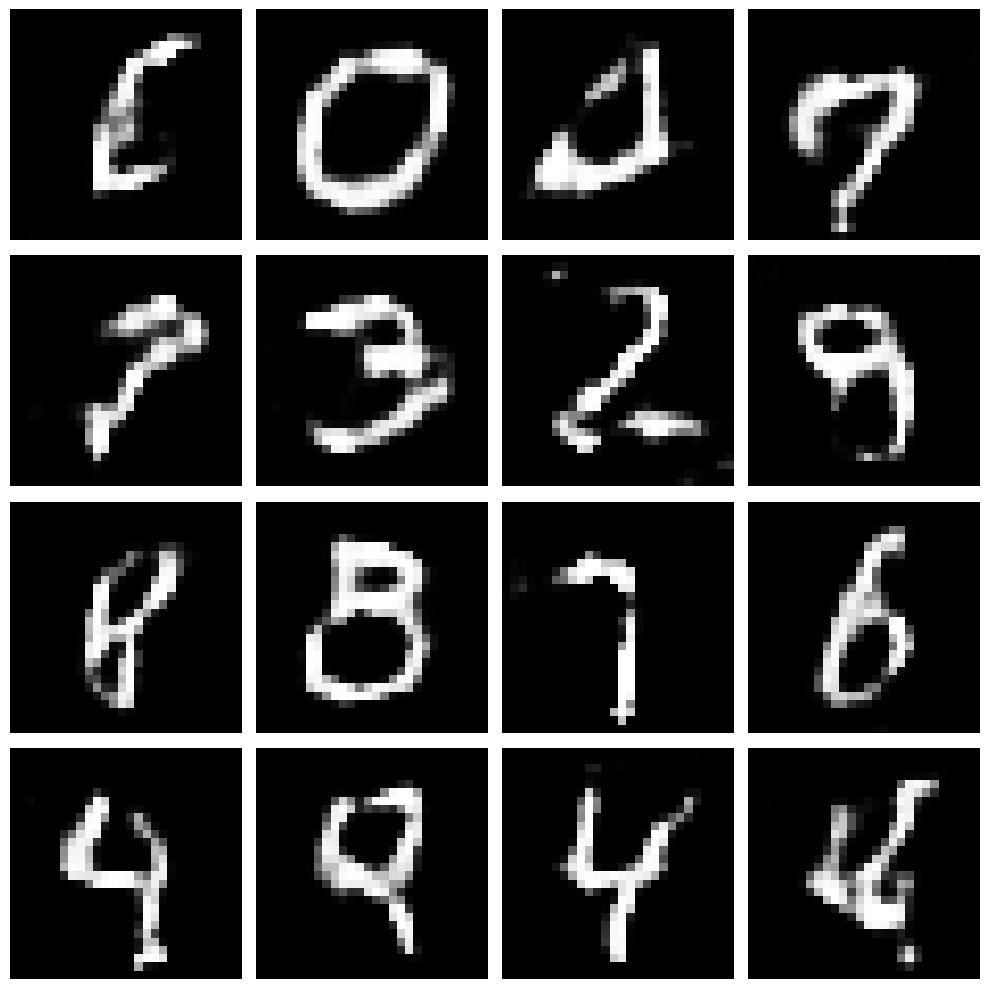

In [9]:
# Display sample generated images
noise = tf.random.normal([16, 100])
generated_images = generator(noise, training=False)

plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 10. Create GIF of Training Progression

In [10]:
import imageio
import glob

anim_file = 'gan_training.gif'

with imageio.get_writer(anim_file, mode='I', duration=0.5) as writer:
    filenames = glob.glob(os.path.join(save_dir, 'image*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)
    # Add the last frame multiple times for longer display
    image = imageio.v2.imread(filenames[-1])
    for _ in range(10):
        writer.append_data(image)

print(f"Training GIF saved as {anim_file}")

Training GIF saved as gan_training.gif
